In [89]:
import numpy as np 
import pandas as pd 

#from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler

import string

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
df = pd.read_csv('/content/drive/MyDrive/5000.csv')
print("Len: " + str(len(df)))

Len: 1440068


In [122]:
filtered_data = df
filtered_data = filtered_data[(filtered_data['author.playtime_at_review'] >= 1000)& (filtered_data['author.num_games_owned'] > 1000)]
print("Len: " + str(len(filtered_data)))

Len: 8115


In [123]:
df=filtered_data 

In [124]:
df=df.rename(columns={'Unnamed: 0': 'index'})

## Extract what user's idea in recomendation of the game

In [126]:
review_df = df[['index', 'recommended']]
review_df['recommended'] = review_df['recommended'].astype(int)
review_df

<ipython-input-126-22e3fd5852e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['recommended'] = review_df['recommended'].astype(int)


,index,recommended
10,469405,1
1276,470671,1
1423,470818,1
2559,471955,1
2997,472393,1
...,...,...
1429437,11531614,1
1436797,10993582,1
1437327,10994112,1
1437747,10994532,1


## Data Preprocessing

In [127]:
Columns = ['index','app_name','language','review']
df_target = df.loc[:, Columns]
df_target.head()

,index,app_name,language,review
10,469405,Half-Life,english,"Classic of the classics, never gets outdated. ..."
1276,470671,Half-Life,english,"[code]\n #+###,,::, , ..."
1423,470818,Half-Life,polish,Jak ktoś miał pirackie CD w latach 2003-2011 t...
2559,471955,Half-Life,english,22 years old is this little game and i've just...
2997,472393,Half-Life,turkish,Asla eskimedi warcraft 3 ve diablo ile tanışma...


In [128]:
df = df.drop(columns=Columns)
df.columns

Index(['app_id', 'review_id', 'timestamp_created', 'timestamp_updated',
       'recommended', 'votes_helpful', 'votes_funny', 'weighted_vote_score',
       'comment_count', 'steam_purchase', 'received_for_free',
       'written_during_early_access', 'author.steamid',
       'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')

In [129]:
df = df.drop(['review_id', 'app_id', 'timestamp_created', 'timestamp_updated', 'author.steamid'], axis=1)


In [130]:
df

,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
10,True,1,0,0.523810,0,True,False,False,2331,316,1375.0,0.0,1375.0,1.562526e+09
1276,True,2,0,0.552239,0,True,False,False,3824,41,1198.0,9.0,1188.0,1.610323e+09
1423,True,1,0,0.523810,0,True,False,False,1198,46,1840.0,102.0,1290.0,1.609924e+09
2559,True,36,1,0.750903,0,False,False,False,2144,14,1127.0,0.0,1127.0,1.608329e+09
2997,True,1,0,0.505034,0,True,False,False,1962,963,1270.0,0.0,1270.0,1.438109e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429437,True,8,1,0.625127,0,True,False,False,7510,71,1629.0,0.0,1629.0,1.600977e+09
1436797,True,0,0,0.000000,0,True,False,True,1519,20,1251.0,0.0,1017.0,1.609714e+09
1437327,True,0,0,0.000000,0,True,False,True,1451,4,3541.0,0.0,3360.0,1.606930e+09
1437747,True,0,0,0.000000,0,True,False,True,1867,5,3550.0,0.0,3539.0,1.606329e+09


In [131]:
scaler = MinMaxScaler()
df[list(df.columns)] = scaler.fit_transform(df[list(df.columns)])
df_target.head(20)

,index,app_name,language,review
10,469405,Half-Life,english,"Classic of the classics, never gets outdated. ..."
1276,470671,Half-Life,english,"[code]\n #+###,,::, , ..."
1423,470818,Half-Life,polish,Jak ktoś miał pirackie CD w latach 2003-2011 t...
2559,471955,Half-Life,english,22 years old is this little game and i've just...
2997,472393,Half-Life,turkish,Asla eskimedi warcraft 3 ve diablo ile tanışma...
3697,473093,Half-Life,turkish,Bu oyunu oynamayanı vururum\n\nOynayacaksınız....
4620,474016,Half-Life,english,A true classic. While some parts of the game ...
5451,527167,Counter-Strike: Source,latam,Un clásico
8436,530152,Counter-Strike: Source,english,Old but old.
9001,530717,Counter-Strike: Source,dutch,Always CS!


In [132]:
df

,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
10,1.0,0.000869,0.000000,0.537671,0.0,1.0,0.0,0.0,0.063279,0.061201,0.000310,0.000000,0.000324,0.829837
1276,1.0,0.001738,0.000000,0.566853,0.0,1.0,0.0,0.0,0.134313,0.007772,0.000164,0.000448,0.000162,0.996319
1423,1.0,0.000869,0.000000,0.537671,0.0,1.0,0.0,0.0,0.009373,0.008743,0.000694,0.005077,0.000251,0.994930
2559,1.0,0.031277,0.004292,0.770775,0.0,0.0,0.0,0.0,0.054382,0.002526,0.000105,0.000000,0.000110,0.989374
2997,1.0,0.000869,0.000000,0.518398,0.0,1.0,0.0,0.0,0.045723,0.186905,0.000223,0.000000,0.000233,0.396474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429437,1.0,0.006950,0.004292,0.641670,0.0,1.0,0.0,0.0,0.309687,0.013600,0.000520,0.000000,0.000543,0.963767
1436797,1.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.024646,0.003691,0.000208,0.000000,0.000015,0.994198
1437327,1.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.021410,0.000583,0.002101,0.000000,0.002039,0.984500
1437747,1.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.041203,0.000777,0.002108,0.000000,0.002193,0.982407


In [133]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [134]:
# New imports 
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

In [135]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

# Should we inlcude title in our analysis?
include_title = False

# some heavy preprocess
i = 0 
def process_row(row):
    global i 
    global include_title
    print("Tfidf Progress: "+str("{:.5f}".format(i/(len(df_target)-1) *100)) + "%",end="\r")
    i += 1
    
    language = row['language']
    reuslt = None
    if(include_title):
        result = (str(row['review']) + " " + str(row['app_name'])).replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
    else:
        result = (str(row['review'])).replace(u'\ufffd', '8')  # Replaces the ASCII '�' symbol with '8'
    result = result.replace(',', '')                       # Removes commas
    result = result.rstrip('\n')                           # Removes line breaks
    result = result.casefold()                             # Makes all letters lowercase

    words_to_remove = ["the", "this", "of", "that", "and", "with", "its"]
    for word in words_to_remove:
      pattern = r'\b{}\b'.format(word)  # Regex pattern to match the specified word as a whole word
      result = re.sub(pattern, '', result)

    words_to_replace = ["to", "it", "is", "in", "but", "for", "are", "as", "not", "on", "or", "have", "if", "de", "shi", "que", "you", "yi", "ne", "wo"]
    for word in words_to_replace:
      pattern = r'\b{}\b'.format(word)  # Regex pattern to match the specified word as a whole word
      result = re.sub(pattern, '', result)

    result = re.sub('\W_',' ', result)        # removes specials characters and leaves only words
    result = re.sub("\S*\d\S*"," ", result)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    result = re.sub("\S*@\S*\s?"," ", result) # removes emails and mentions (words with @)
    result = re.sub(r'http\S+', '', result)   # removes URLs with http
    result = re.sub(r'www\S+', '', result)    # removes URLs with www
    
    result = re.sub(r"\s+(.)\1+\b", "",result)               # remove spammed chars
    result = ''.join([i for i in result if not i.isdigit()]) # remove numbers
    result = re.sub(r'[^\w\s]','',result)                    # remove punctuation
   

    listOfTokens = word_tokenize(result)
    twoLetterWord = twoLetters(listOfTokens)


    try: 
        # Not all languages are supported 
        # We remove stopwords and stem only with supported languages
        stopwords = nltk.corpus.stopwords.words(language)
        stopwords.append("game")
        
        param_stemmer = SnowballStemmer(language)
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, stopwords)
        
        

    finally:
        # Output the tokens
        listOfTokens = list(filter(lambda item: len(item) < 25,listOfTokens))   # other spam filter
        listOfTokens = removeWords(listOfTokens, ["game","gam","igr","juego","you","jogao"]) # some game translations (en,en,ru,sp,ch,pt)
        
        result   = " ".join(listOfTokens)
        result = unidecode(result)
        result = re.sub(r'[^\x00-\x7F]+','', result)    # remove non ascii

        return result
    


In [136]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [137]:
%%time
df_target['tokens'] = df_target.apply(lambda row: process_row(row),axis=1)

CPU times: user 17.2 s, sys: 1.23 s, total: 18.4 s
Wall time: 17.6 s


In [138]:
df_target

,index,app_name,language,review,tokens
10,469405,Half-Life,english,"Classic of the classics, never gets outdated. ...",classicclassics never gets outdated oldschool ...
1276,470671,Half-Life,english,"[code]\n #+###,,::, , ...",code www w w ww www w w w w w ww code
1423,470818,Half-Life,polish,Jak ktoś miał pirackie CD w latach 2003-2011 t...,jak ktos mial pirackie cd w latachwarto uczciw...
2559,471955,Half-Life,english,22 years old is this little game and i've just...,years oldlittle ive just playedvery first time...
2997,472393,Half-Life,turkish,Asla eskimedi warcraft 3 ve diablo ile tanışma...,asla eskimedi warcraftve diablo ile tanismadan...
...,...,...,...,...,...
1429437,11531614,There Is No Game: Wrong Dimension,spanish,[quote]Para más reseñas como esta sígueme [b][...,quotepara mas resenas como esta siguememi pagi...
1436797,10993582,Townscaper,italian,Best city builder ever. \nNo citizen complain.,best city builder ever no citizen complain
1437327,10994112,Townscaper,english,"It's a unique, low stress game that at the sam...",s a unique low stress at same time can be chal...
1437747,10994532,Townscaper,english,"If it isn't clear by the previews, this is not...",isnt clear by previewsa gametraditional sense ...


In [139]:
%%time
# tf-idf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_target['tokens'])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

tf_idf.head()

CPU times: user 1.07 s, sys: 1.02 s, total: 2.08 s
Wall time: 2.07 s


,0cao,0sabaibarugale,0sutoresunoge,0yarizhi,0zong,2hosts,_z,aa,aaa,aaaa,...,zyskala,zyski,zywicy,zywicznej,zywiolow,zywnosc,zywo,zywota,zywotnosc,zywy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
%%time
bool_list = ['recommended','steam_purchase','received_for_free','written_during_early_access']
df[bool_list] = df[bool_list].astype(int)

CPU times: user 5.78 ms, sys: 46 µs, total: 5.83 ms
Wall time: 5.52 ms


In [141]:
# Combine data
df = pd.concat([df, tf_idf], axis=1)

In [142]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
    
df = clean_dataset(df)

<ipython-input-142-2df673b22ae6>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)


In [143]:
df.head()

,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.num_games_owned,author.num_reviews,...,zyskala,zyski,zywicy,zywicznej,zywiolow,zywnosc,zywo,zywota,zywotnosc,zywy
10,1.0,0.000869,0.000000,0.537671,0.0,1.0,0.0,0.0,0.063279,0.061201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1276,1.0,0.001738,0.000000,0.566853,0.0,1.0,0.0,0.0,0.134313,0.007772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1423,1.0,0.000869,0.000000,0.537671,0.0,1.0,0.0,0.0,0.009373,0.008743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2559,1.0,0.031277,0.004292,0.770775,0.0,0.0,0.0,0.0,0.054382,0.002526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2997,1.0,0.000869,0.000000,0.518398,0.0,1.0,0.0,0.0,0.045723,0.186905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
%%time
df_ = df.copy()

pca__ = IncrementalPCA(n_components = 7, batch_size=128)
reduced = pca__.fit_transform(df)

CPU times: user 1.73 s, sys: 1.29 s, total: 3.02 s
Wall time: 1.46 s


In [145]:
columns__ = ['pca_comp_%i' % i
   for i in range(reduced.shape[1])
]

df = pd.DataFrame(data = reduced
             , columns = columns__)
df.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6
0,0.320171,-0.045425,-0.036956,0.689656,0.386395,-0.343587,0.304535
1,0.314098,0.155518,0.175970,0.321412,-0.128509,0.805600,-0.126099
2,0.291303,0.136606,0.321396,-0.333806,0.532597,-0.150280,-0.560285
3,-0.899655,0.679766,-0.506241,-0.038765,0.048688,-0.005454,0.002587
4,0.411367,-0.580954,-0.775996,-0.174347,-0.105590,0.029000,-0.158359


In [146]:
def elbow(df): # Elbow method for best k
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}

    K = range(1, 8)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)

        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / df.shape[0])
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                       'euclidean'), axis=1)) / df.shape[0]
        mapping2[k] = kmeanModel.inertia_

        print("Iter "+str(k)+" of "+str(max(K))+" done...")
    
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()
    
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

Iter 1 of 7 done...
Iter 2 of 7 done...
Iter 3 of 7 done...
Iter 4 of 7 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

Iter 5 of 7 done...
Iter 6 of 7 done...
Iter 7 of 7 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


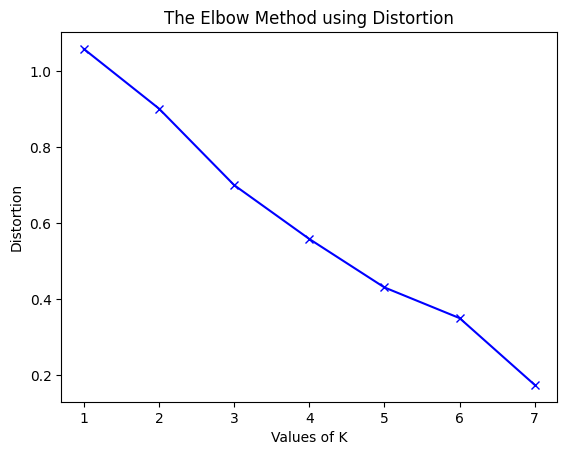

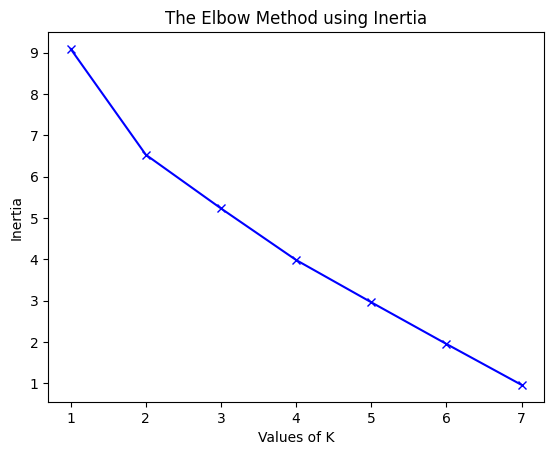

CPU times: user 2.85 s, sys: 856 ms, total: 3.7 s
Wall time: 604 ms


In [147]:
%%time
elbow(df)

In [148]:
optimal = 2
kmeans = KMeans(n_clusters=optimal).fit(tf_idf)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [149]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

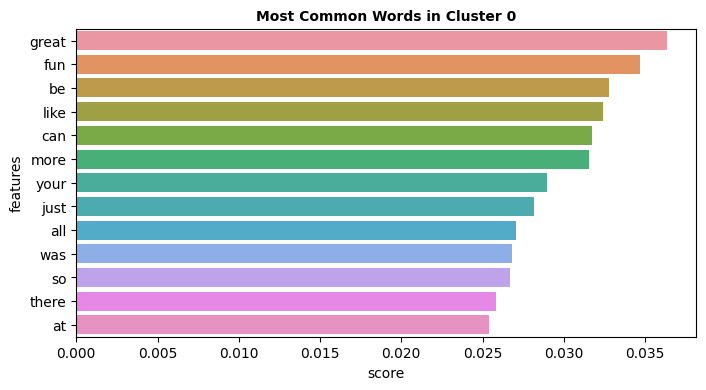

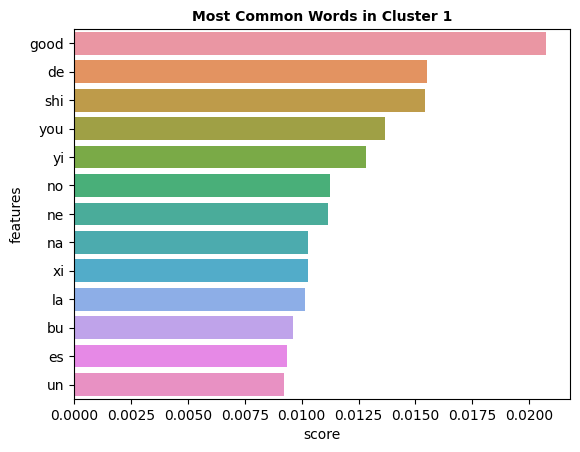

In [150]:
final_df_array = tf_idf.to_numpy()
prediction = kmeans.predict(tf_idf)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [151]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


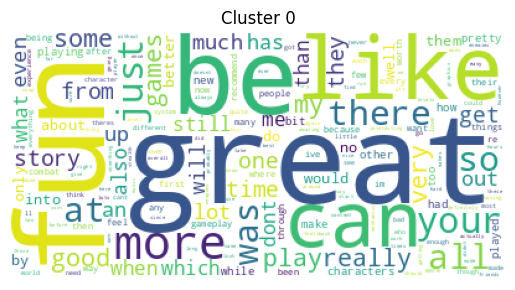

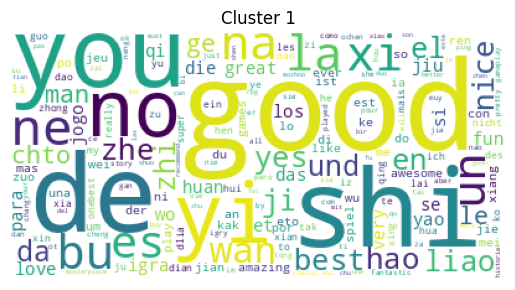

In [152]:
from wordcloud   import WordCloud
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = tf_idf.columns
generateWordClouds(centroids)

In [153]:
# Filter data  that have less or equal to 512 tokens
df_target = df_target[df_target['tokens'].notnull()]
#df_target.filter(len(str(df_target.tokens).split())<500)
df_target2 = df_target[df_target["tokens"].apply(lambda x: len(x) <500)]
#df["names"].apply(lambda x: len(x) > 500)
df_target2


,index,app_name,language,review,tokens
10,469405,Half-Life,english,"Classic of the classics, never gets outdated. ...",classicclassics never gets outdated oldschool ...
1276,470671,Half-Life,english,"[code]\n #+###,,::, , ...",code www w w ww www w w w w w ww code
1423,470818,Half-Life,polish,Jak ktoś miał pirackie CD w latach 2003-2011 t...,jak ktos mial pirackie cd w latachwarto uczciw...
2559,471955,Half-Life,english,22 years old is this little game and i've just...,years oldlittle ive just playedvery first time...
2997,472393,Half-Life,turkish,Asla eskimedi warcraft 3 ve diablo ile tanışma...,asla eskimedi warcraftve diablo ile tanismadan...
...,...,...,...,...,...
1422767,10902290,ULTRAKILL,english,"One of the best fast-paced FPS ever made, and ...",onebest fastpaced fps ever madehasnt even come...
1424485,10904008,ULTRAKILL,english,This is legitimately one of the best FPS games...,legitimately onebest fps games ive played year...
1436797,10993582,Townscaper,italian,Best city builder ever. \nNo citizen complain.,best city builder ever no citizen complain
1437327,10994112,Townscaper,english,"It's a unique, low stress game that at the sam...",s a unique low stress at same time can be chal...


In [154]:
df_target2.to_csv("data_target2.csv", index=False, encoding='utf-8-sig')

In [155]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 9

In [156]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [157]:
import transformers
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")
data = df_target2["tokens"].tolist()
results=sentiment_pipeline(data)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [160]:
# Extract score and label columns from results
scores = [res["score"] for res in results]
labels = [res["label"] for res in results]

# Create new dataframe with app_name, score, and label columns
new_df = pd.DataFrame({
    "id":df_target2["index"],
    "app_name": df_target2["app_name"],
    "score": scores,
    "label": labels
})

In [161]:
new_df

,id,app_name,score,label
10,469405,Half-Life,0.997356,POSITIVE
1276,470671,Half-Life,0.965920,NEGATIVE
1423,470818,Half-Life,0.978352,NEGATIVE
2559,471955,Half-Life,0.997037,POSITIVE
2997,472393,Half-Life,0.993416,NEGATIVE
...,...,...,...,...
1422767,10902290,ULTRAKILL,0.993809,POSITIVE
1424485,10904008,ULTRAKILL,0.993536,POSITIVE
1436797,10993582,Townscaper,0.999765,POSITIVE
1437327,10994112,Townscaper,0.993615,POSITIVE


In [162]:
new_df.to_csv("sentiment_analysis_resultsNEWNEW.csv", index=False)

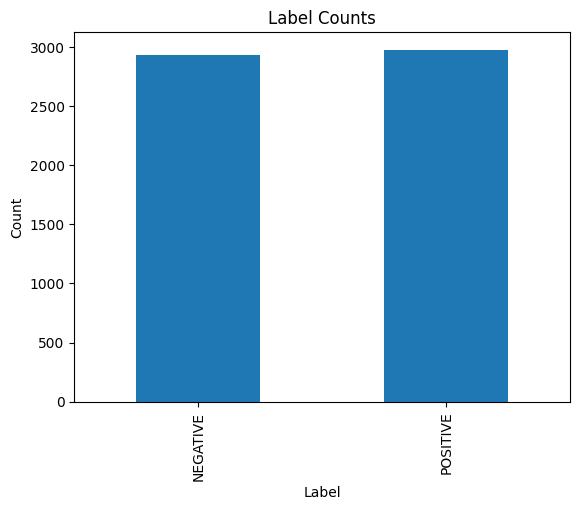

In [174]:
label_counts = new_df.groupby('label').size()
label_counts.plot(kind='bar')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


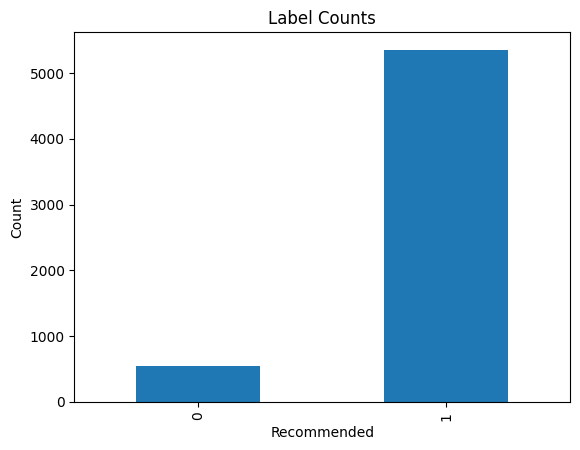

In [178]:
merged_df = pd.merge(new_df, review_df, how='left', left_on='id', right_on='index')
merged_df = merged_df.groupby('recommended').size()
merged_df.groupby('recommended')
merged_df.plot(kind='bar')
plt.title('Label Counts')
plt.xlabel('Recommended')
plt.ylabel('Count')
plt.show()

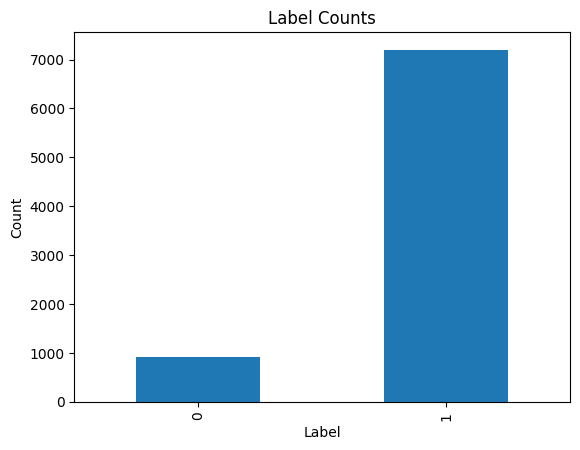

In [179]:
## All the data being input to the model
recommend = review_df.groupby('recommended').size()
recommend.plot(kind='bar')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()